In [40]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import dill as pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import torch
import nibabel as nb

import nctpy

from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
DATA7_PATH = "/System/Volumes/Data/data/data7"
projects_path = f"{DATA7_PATH}/network_control/projects"
sys.path.insert(1, projects_path)
import CAP_tools


NC_path = f"{DATA7_PATH}/network_control/projects/network_control"
sys.path.insert(1, NC_path)
import plot
import surface_mapping as sfm
# from network_control import plot

# Parameters

In [4]:
N_PARCELS = 400

# Constants

In [5]:
DTI_parcellation = f"Schaefer2018_{N_PARCELS}Parcels_17Networks_order_FSLMNI152_1mm"
fMRI_parcellation = DTI_parcellation.split("_order")[0]

subjects_list_file = f"{DATA7_PATH}/HCP_7T/scripts/_params/subject_list.txt"
parcellation_list_file = f"{DATA7_PATH}/HCP_7T/scripts/_params/parcellations.txt"
HCP_7T_DIR = f"{DATA7_PATH}/HCP_7T"
HCP_7T_fMRI_DIR = os.path.join(HCP_7T_DIR, "{subject}/MNINonLinear/Results/{data_type}")

pkl_cache_format = "cache/HCP_CAP_{filename}.pkl"

In [6]:
with open(subjects_list_file, 'r') as f:
    subject_list = sorted(f.read().split())

with open(parcellation_list_file, "r") as file:
    parcellation_path_dict = dict(line.strip().split(": ") for line in file.readlines())

fMRI_parcellation_path = parcellation_path_dict[fMRI_parcellation]
avoid_subjects = ["585256", #tfMRI movie2 PA missing, all rest intact
                  "102311", # DTI import failed, unclear if missing or what
]
subject_list = [s for s in subject_list if not s in avoid_subjects]

# Load ptseries 

In [8]:
def load_HCP_7T_nii(subject, data_type, file_type, fMRI_parcellation="", 
                    data_ext="_hp2000_clean_nilearn_ISCH"):
    """ """
    fMRI_parcellation = "_" + fMRI_parcellation if fMRI_parcellation != "" else ""
    subject_fmri_dir = HCP_7T_fMRI_DIR.format(subject=subject, data_type=data_type)
    pt_series_name = f"{data_type}_Atlas{data_ext}{fMRI_parcellation}.{file_type}.nii"
    subject_ptseries = os.path.join(subject_fmri_dir, pt_series_name)
    return nb.load(subject_ptseries)

In [9]:
data_types = ["rfMRI_REST1_7T_PA", "tfMRI_MOVIE_7T_DAY_1"]
data_exts = ["_hp2000_clean_nilearn", "_hp2000_clean_nilearn_ISCH"]

In [10]:
tf_arrays = {}
tf_arrays["rfMRI_all"] = []
tf_arrays["tfMRI_all"] = []

for subject in tqdm(subject_list, desc=f"Loading ptseries"):
    subj_data = {}
    for data_type, data_ext in zip(data_types, data_exts):
        
        cifti = load_HCP_7T_nii(subject, data_type, "ptseries",
                                fMRI_parcellation=fMRI_parcellation, data_ext=data_ext)
        subj_data[data_type] = np.array(cifti.get_fdata())

    rf_array = np.vstack([subj_data[dt] for dt in data_types if "rfMRI" in dt])
    tf_array = np.vstack([subj_data[dt] for dt in data_types if "tfMRI" in dt])
    tf_arrays["rfMRI_all"].append(rf_array)
    tf_arrays["tfMRI_all"].append(tf_array)

tf_arrays["rfMRI_all"] = np.array(tf_arrays["rfMRI_all"])
tf_arrays["tfMRI_all"] = np.array(tf_arrays["tfMRI_all"])
template_cifti = cifti

rfMRI_all = tf_arrays["rfMRI_all"]
tfMRI_all = tf_arrays["tfMRI_all"]
rfMRI_all.shape, tfMRI_all.shape

Loading ptseries:   0%|          | 0/174 [00:00<?, ?it/s]

((174, 900, 400), (174, 1432, 400))

In [11]:
ROI_labels = [label for label, _, index in template_cifti.header.get_axis(1)]
clean_ROI_labels = [l.split("works_")[1] for l in ROI_labels]
network_labels = [l.split("_", maxsplit=3)[2] for l in ROI_labels]

network_label_order = []
_ = [network_label_order.append(net) for net in network_labels if net not in network_label_order]

# Load CAP States

In [12]:
HCP_CAP_state_results_dir = f"{DATA7_PATH}/network_control/results/HCP_7T_analysis/CAP_states"

CAP_analysis_label = "tfMRI_MOVIE_7T_DAY_1"
isc = 0

isc_tag = f"_ISC_{isc * 100:0.0f}" if isc > 0 else ""
K = 12

CAP_analysis_path = f"{HCP_CAP_state_results_dir}/{CAP_analysis_label}{isc_tag}"
CAP_pkl_path = f"{CAP_analysis_path}/{CAP_analysis_label}_CAP_states_K{K}.pkl"

In [13]:
with open(CAP_pkl_path, 'rb') as file:
    CAP_states, CAP_labels, CAP_isc_df, CAP_ROI_labels, CAP_ptseries_paths = pickle.load(file)
    CAP_states = np.array(CAP_states)
    CAP_subjects = [path.split("HCP_7T/")[1].split("/MNI")[0] for path in CAP_ptseries_paths]
    CAP_labels = CAP_labels.reshape(len(CAP_subjects), -1)

assert all(subj in CAP_subjects for subj in subject_list)
assert CAP_labels.shape[1] == tfMRI_all.shape[1]
CAP_labels = CAP_labels[np.isin(CAP_subjects, subject_list)]
assert tfMRI_all.shape[:2] == CAP_labels.shape

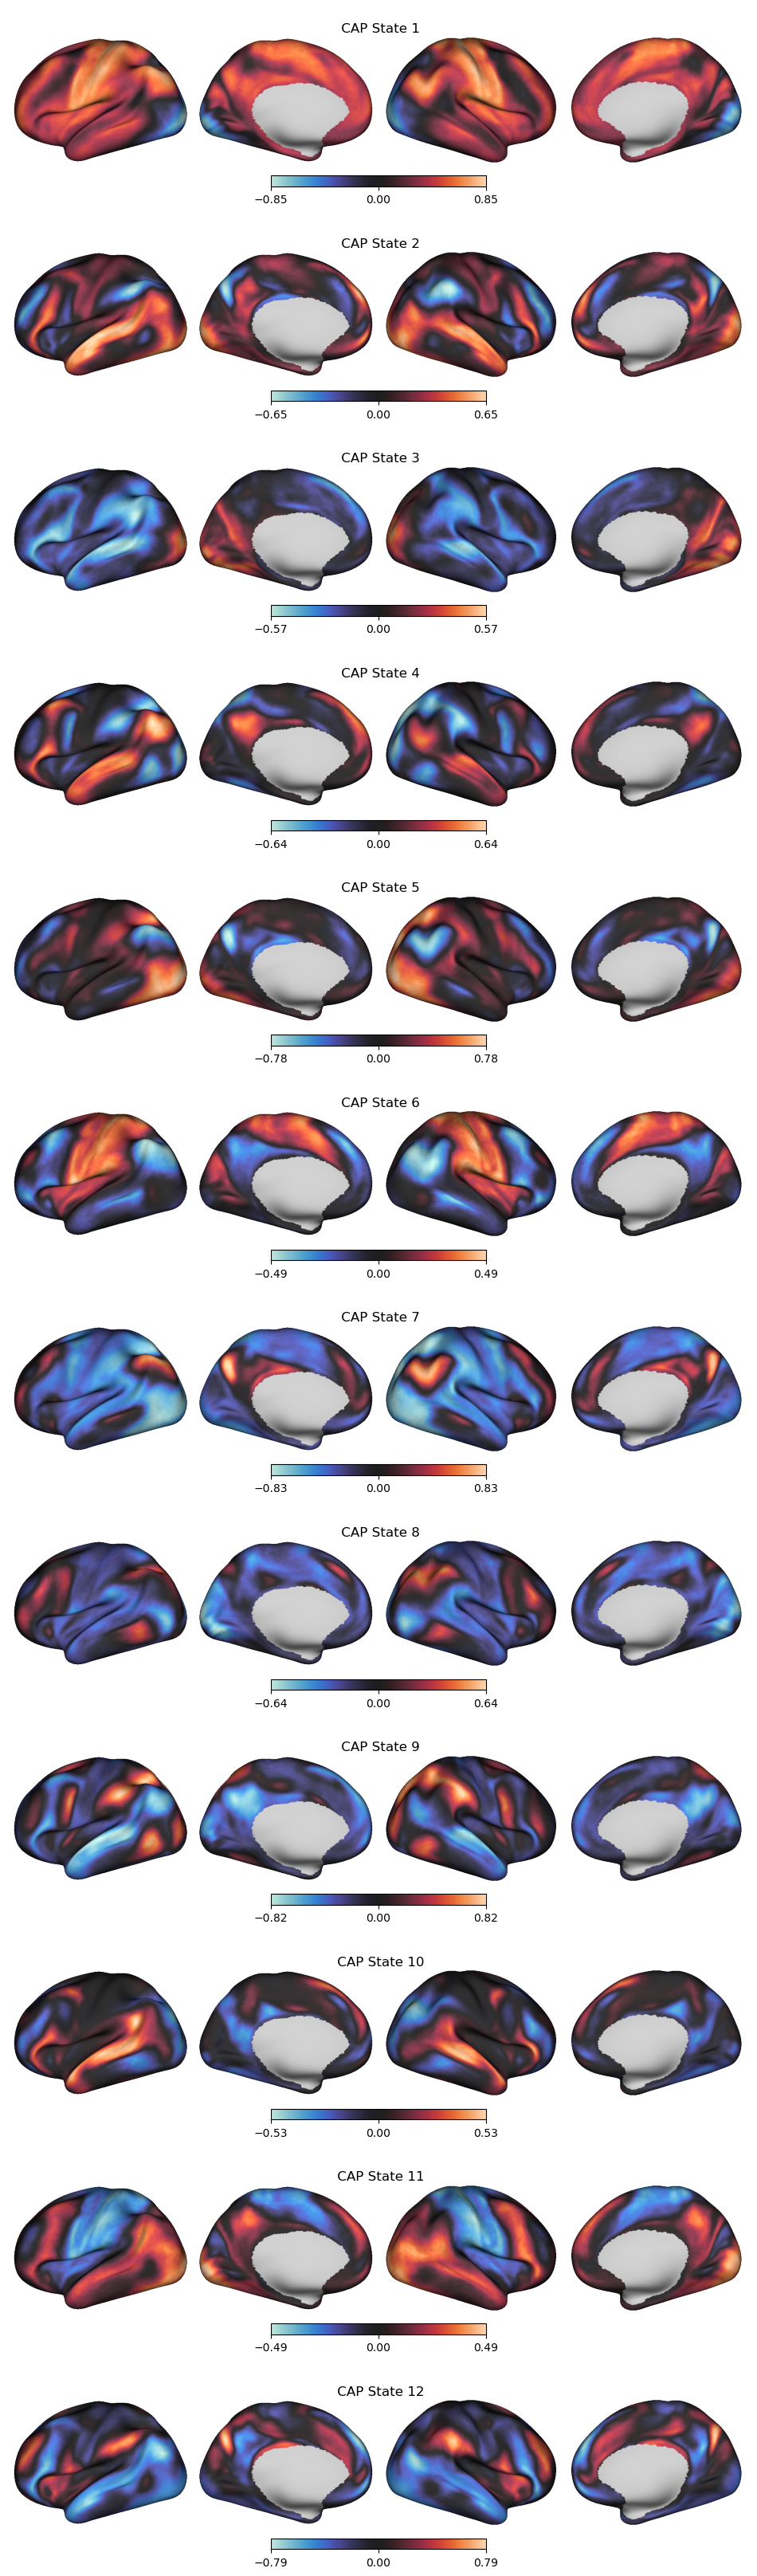

In [15]:
from IPython.display import Image
dCAP_plot_path = os.path.join(CAP_analysis_path, f"{CAP_analysis_label}_plots",
                              f"{CAP_analysis_label}_dCAP_{K}_states.png")
Image(filename=dCAP_plot_path, width=500)

# CAP Occupancy Graph

In [16]:
CAP_occupancy = np.array([np.bincount(TR, minlength=len(CAP_states)) / len(CAP_labels)
                          for TR in CAP_labels.T])
CAP_modes = scipy.stats.mode(CAP_labels, axis=0)[0]

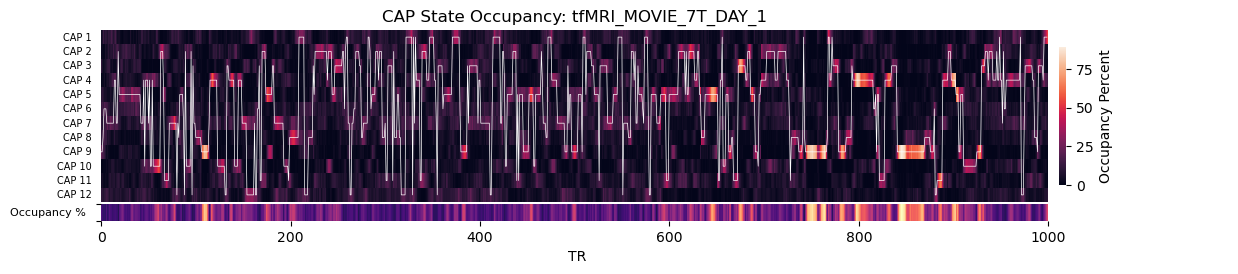

In [17]:
n_TRs = 1000
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax, a1) = plt.subplots(2, 1, figsize=(12, 2.5), height_ratios=[1, 0.1])
fig.tight_layout(h_pad=-2)
sns.heatmap(CAP_occupancy[:n_TRs].T * 100, ax=ax,
            cbar_kws=dict(pad=0.01, shrink=0.8, label="Occupancy Percent"))
ax.plot(CAP_modes[:n_TRs] + 0.5, color="w", alpha=1, linewidth=0.5)
ax.set(xticklabels=[]);
ax.tick_params(left=False, bottom=False, labelsize=8)
ax.set_yticks(np.arange(12) + 0.5)
ax.set_yticklabels([f"CAP {i + 1}" for i, _ in enumerate(CAP_states)], rotation=0, size=7)
ax.set_title("CAP State Occupancy: " + CAP_analysis_label)

pal = sns.color_palette("magma", as_cmap=True)
colors = pal(CAP_occupancy.max(axis=1) / np.max(CAP_occupancy))[:n_TRs]
for i, c in enumerate(colors):
    a1.bar(i, 1, color=c, width=1)
a1.set_xlim(0, len(colors) * 1.19) # 150)
xticks = a1.get_xticks()
a1.set_xticks(xticks[xticks <= len(colors)])
a1.set_xlabel("TR" + " " * 40)
a1.set_ylabel("Occupancy %", rotation=0, va="center", ha="right", size=8)
plt.setp(a1.spines.values(), color=None)
# a1.axes.get_yaxis().set_visible(False)
a1.set(yticklabels=[]);

# CAP Transition Point Analysis 

In [18]:
def znorm(x, axis=None):
    return (x - np.mean(x, axis=axis, keepdims=True)) / np.std(x, axis=axis, keepdims=True)

In [19]:
start_state = 5
end_state = 3

CAP_mode_tp = CAP_modes[:-1] != CAP_modes[1:]
CAP_tp = CAP_labels[:, :-1] != CAP_labels[:, 1:]
# CAP_tp = ((CAP_labels == start_state)[:, :-1] & (CAP_labels == end_state)[:, 1:])
CAP_tp = np.hstack([CAP_tp, np.zeros((len(CAP_tp), 1), dtype=bool)])

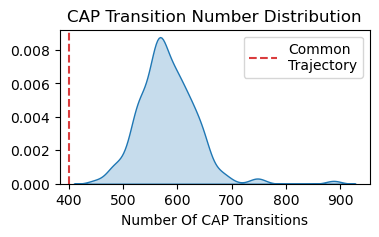

In [24]:
fig, ax = plt.subplots(figsize=(4, 2))
sns.kdeplot(CAP_tp.sum(axis=1), bw_method=0.25, ax=ax, fill=True)
ax.axvline(np.sum(CAP_mode_tp), linestyle="--", color="C3", alpha=0.9, label="Common\nTrajectory")
ax.legend()
plot.label(ax, "Number of CAP Transitions", title="CAP Transition Number Distribution")

In [25]:
CAP_mode_tp = np.where(CAP_mode_tp)[0]
tp_bold = np.array([tfMRI_all[i, CAP_tp[i], :].mean(axis=(0)) for i in range(len(CAP_tp))])

In [26]:
CAP_tp_i_ind = np.where(CAP_tp[0])[0]
CAP_tp_start_states = CAP_states[CAP_labels[0][CAP_tp_i_ind]]
CAP_tp_start_bold = tfMRI_all[0, CAP_tp_i_ind, :]
nCAP_tp_start_bold = CAP_tp_start_bold #/ CAP_tp_start_states
CAP_tp_end_bold = tfMRI_all[0, CAP_tp_i_ind + 1, :]

In [27]:
t, p  = scipy.stats.ttest_rel(CAP_tp_end_bold, CAP_tp_start_bold, axis=0)
q = scipy.stats.false_discovery_control(p)

In [30]:
CAP_tp_end = np.roll(CAP_tp, 1, axis=1)

CAP_tp_all_start_bold = tfMRI_all[CAP_tp, :]
CAP_tp_all_end_bold = tfMRI_all[CAP_tp_end, :]

CAP_tp_all_start_state = CAP_states[CAP_labels[CAP_tp]]
CAP_tp_all_end_state = CAP_states[CAP_labels[CAP_tp_end]]

CAP_tp_starts = CAP_labels[CAP_tp]
CAP_tp_ends = CAP_labels[CAP_tp]
subject_index = np.arange(len(CAP_tp)).repeat(CAP_tp.sum(axis=1))

## Generate Normalize values:

0.9999999999999998


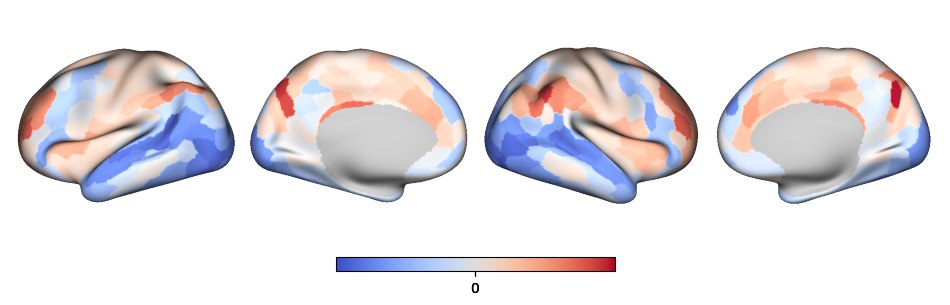

In [34]:
n_CAPs = len(CAP_states)
CAP_tp_starts = CAP_labels[CAP_tp]
CAP_tp_ends = CAP_labels[CAP_tp_end]

weighted_transition_distance = np.zeros(400)
tp_weights = np.zeros(np.sum(CAP_tp))
w_t = 0
for i in range(n_CAPs):
    for j in range(n_CAPs):
        if i == j:
            continue
        delta_ij = CAP_states[i] - CAP_states[j]
        tp_ij_inds = (CAP_tp_starts == i) & (CAP_tp_ends == j)
        # tp_ij_inds = ((CAP_labels == i)[:, :-1] & (CAP_labels == j)[:, 1:]).ravel()
        w_ij = ((CAP_labels == i)[:, :-1] & (CAP_labels == j)[:, 1:]).mean()
        w_ij = tp_ij_inds.mean()

        tp_weights[tp_ij_inds] = w_ij
        
        weighted_transition_distance += w_ij * delta_ij
        w_t += w_ij

print(w_t)
tp_weights /= tp_weights.sum()
CAP_transition_diff_values = CAP_tools.utils.cifti_map(ROI_labels, weighted_transition_distance, template_cifti)
a0, p = sfm.surface_plot(CAP_transition_diff_values, cmap=plt.cm.coolwarm, alpha=1, cbar=True, uniform_cbar=False)

# Transition Point Mean BOLD Change

<Axes: ylabel='Density'>

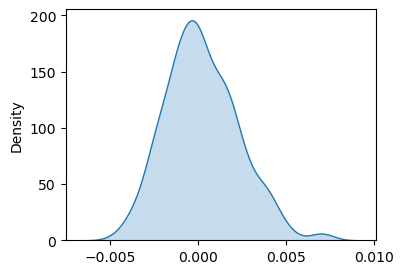

In [35]:
CAP_transition_diff = CAP_tp_all_start_state - CAP_tp_all_end_state
tp_delta = CAP_tp_all_start_bold - CAP_tp_all_end_bold
n_tp_delta = tp_delta * tp_weights.reshape(-1, 1)
n_tp_delta = tp_delta / weighted_transition_distance
n_tp_delta = tp_delta - CAP_transition_diff
# n_tp_delta = (tp_delta - CAP_transition_diff) * tp_weights.reshape(-1, 1)

mean_ndelta = np.mean(n_tp_delta, axis=0)
fig, ax = plt.subplots(figsize=(4, 3))
sns.kdeplot(mean_ndelta, bw_method=0.3, fill=True)

In [36]:
t, p_vals  = scipy.stats.ttest_1samp(n_tp_delta, 0, axis=0, alternative="two-sided")
q = scipy.stats.false_discovery_control(p_vals)
print("Total Significant P Values", np.sum(p_vals < 0.05))
print("Total Significant Q Values", np.sum(q < 0.05))

Total Significant P Values 103
Total Significant Q Values 45


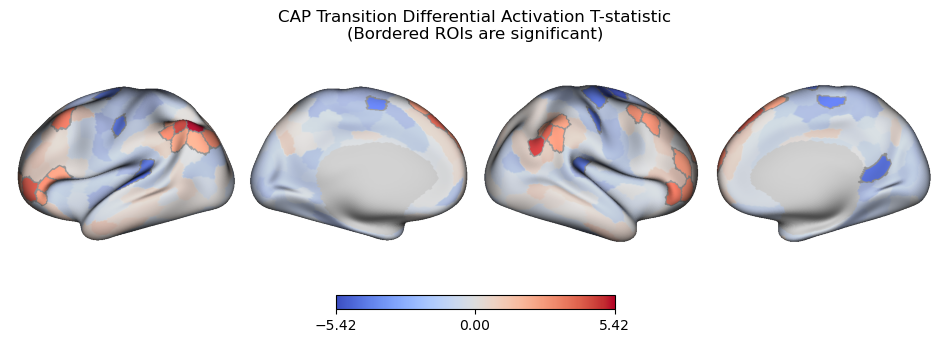

In [38]:
t_sig = np.repeat(np.nan, len(t))
# sig_ind = p_vals < 0.05
sig_ind = q < 0.05
t_sig[sig_ind] = t[sig_ind]
t_values = CAP_tools.utils.cifti_map(ROI_labels, t, template_cifti)
a0, p = sfm.surface_plot(t_values, cmap=plt.cm.coolwarm, alpha=.4, cbar=True, uniform_cbar=True)

color_range = p.color_ranges[-1]
t_sig_values = CAP_tools.utils.cifti_map(ROI_labels, t_sig, template_cifti)
a0, p = sfm.surface_plot(t_sig_values, cmap=plt.cm.coolwarm, cbar=False, color_range=color_range,
                         alpha=1, outline=True, p=p,  ax=a0)
a0.set_title(f"CAP Transition Differential Activation T-statistic\n(Bordered ROIs are significant)");

## Associated Networks

In [55]:
sn_tp_delta = np.array([n_tp_delta[subject_index == i].mean(axis=0) for i in np.arange(len(CAP_tp))])
nlu = sorted(set(network_labels))
net_sig = np.array(network_labels)[q < 0.05].tolist()
nlu_per_sig = [net_sig.count(net) * 100 / network_labels.count(net) for net in nlu]

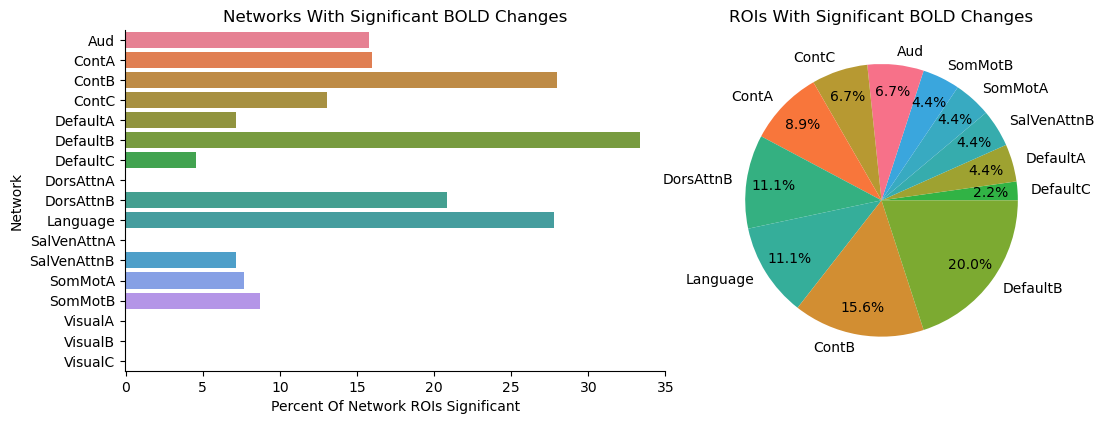

In [56]:
fig, (a0, a1) = plt.subplots(1, 2, figsize=(11, 4))
fig.tight_layout(w_pad=-7)
sns.barplot(x=nlu_per_sig, y=nlu, width=0.8, ax=a0, hue=nlu)
a0.set_xlim(-0.05, None)
plot.label(a0, "Percent of Network ROIs Significant", "Network", "Networks with Significant BOLD Changes")
a0.spines[['right', 'top']].set_visible(False)

labels, sizes = np.unique(net_sig, return_counts=True)
si = np.argsort(sizes)
pal = sns.color_palette("husl", len(nlu))
a1.pie(sizes[si], labels=labels[si], colors=np.array(pal)[si],
       autopct='%1.1f%%', pctdistance=.8);
plot.label(a1, title="ROIs with Significant BOLD Changes")

# Association with NCT metrics

### Load in DTI

In [42]:
# TODO: Assess normalizing by sum
NORM_STREAMLINES = 2_500_000

def load_trk_A(mat_path, total_streamlines=NORM_STREAMLINES):
    A = scipy.io.loadmat(mat_path)["connectivity"].astype(int)
    normed_A = A / np.sum(A) * total_streamlines
    return normed_A

In [43]:
cache_path = pkl_cache_format.format(filename="load_DTI")

raw_AT_set = []
for subject in tqdm(subject_list, desc="Loading DTI Connectomes"):
    DTI_dir = os.path.join(HCP_7T_DIR, subject, "T1w/Diffusion_7T/DTI_results")
    mat_path = f"{DTI_dir}/{subject}.{DTI_parcellation}.count.pass.connectivity.mat"

    assert os.path.exists(mat_path), f"{subject} DTI missing."
    raw_AT_set.append(load_trk_A(mat_path))
    
raw_AT_set = np.array(raw_AT_set)

Loading DTI Connectomes:   0%|          | 0/174 [00:00<?, ?it/s]

In [48]:
raw_AT_mean = np.mean(raw_AT_set, axis=0)
dnorm_AT_mean = nctpy.utils.matrix_normalization(raw_AT_mean, system="discrete")

avc = nctpy.metrics.ave_control(dnorm_AT_mean, system="discrete")
mdc = nctpy.metrics.modal_control(dnorm_AT_mean)

Text(0.5, 0.98, 'CAP Transition Differential Activation and Controllability')

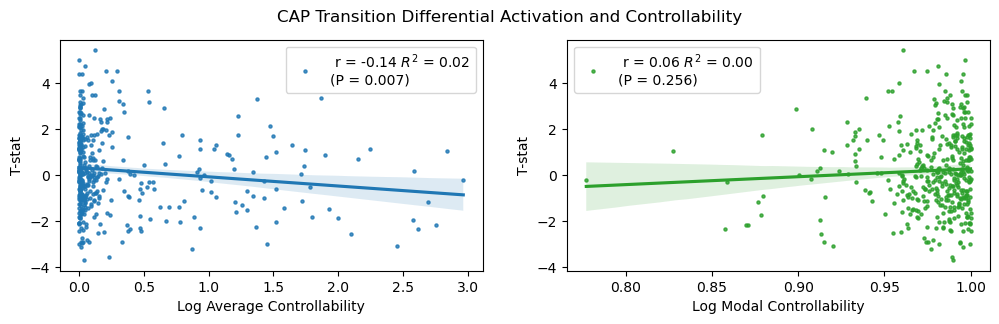

In [50]:
fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 3))
plot.regplot(np.log10(avc), t, ax=a0, scatter_kws=dict(s=5))
plot.regplot(mdc, t, ax=a1, color="C2", scatter_kws=dict(s=5))
plot.label(a0, "log Average Controllability", "T-stat", "")
plot.label(a1, "log Modal Controllability", "T-stat", "")
fig.suptitle("CAP Transition Differential Activation and Controllability")

## TODO:
[] G1. Look at transition point activation that stays high, ie pre transition point is higher than 'average' or non transition points

[] G2. repeat G1 for only specific transition points - identify transition specific set and transition, non-specific set.

[] Controls: Compare against preceding CAP time points? i.e. CAP for 4 TRs and then transition, compare BOLD at transition to BOLD for prior 3 TRs